Importy

`data_generation` to skrypt napisany przeze mnie służący do generowania danych - zaimportowanie go może trwać kilka sekund, bo jest on napisany dość głupio i wraz z odpaleniem ładowany zostaje MNIST.

In [1]:
import torch
import torch.nn as nn
import numpy as np
# import generate_data
import numpy as np
from tqdm import tqdm
import sys
from os import system
import matplotlib.pyplot as plt
import pickle

import data_generation

Zadaniem modeli będzie rozpoznawanie cyfr wyświetlanych na poszczególnych klatkach. Przykładowe dane można zobaczyć tutaj (należy odtworzyć plik `examlpe.mp4`) - nie udało mi się dogadać z jupyterem w kontekście odtwarzania fimów.

`noise_prob` - prawdopodobieństwo zmiany piksela (każdy piksel zostanie zmieniony z tym prawdopodobieństwem. Zmienione piksele mają natężenie losowane z rozkładu jednostajnego)

`img_len_func` - rozkład długości trwania (ilości klatek) pojedyńczej cyfry

`no_imgs_func` - rozkład liczby cyfr przypadającej na jeden filmik


In [48]:
data, label = data_generation.gen_data(1,
                                       noise_prob=0.1,
                                       img_len_func=lambda: np.random.geometric(0.1),
                                       no_imgs_func=lambda: np.random.geometric(0.1),
)
data_generation.save_video(data[0], filepath='example.mp4')
print(label)

Processing: 100%|██████████| 1/1 [00:00<00:00, 14.30iteration/s]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4], dtype=uint8)]


Wszystkie modele na wejściu mają zmiennej długości ciąg zaszumionych obrazów rozmiaru `28x28`, a na wyjściu 10 liczb rzeczywistych. Wzorcową odpowiedzią dla klatki wyświetlającej cyfrę $a$ jest wektor one-hot, aktywny na współrzędnej $a$. Funkcją straty jest entropia krzyżowa.

In [2]:
def get_valid_loss(model, data, labels, valid_size=50):
    random_indices = np.random.choice(len(data), size=valid_size, replace=False)
    valid_random_data = []
    valid_random_labels = []
    
    for i in random_indices:
        valid_random_data.append(data[i])
        valid_random_labels.append(labels[i])
            
    # valid_random_data = torch.stack(valid_random_data)
    
    loss = []
    
    with torch.no_grad():
        for input, label in zip(valid_random_data, valid_random_labels):
            prediction, _ = model(input)
            loss.append(torch.nn.functional.cross_entropy(prediction, label))
        return np.mean(loss)

Główna pętla uczenia, wykorzystywana przez wszysktie modele. Ustawienie argumentu `show_graph` na `True` spowoduje wyświetlanie wartości funkcji straty w czasie rzeczywistym. Niestety na moim jupyterze to nie działa - u mnie aby oglądać postęp w czasie rzeczywistym trzeba odpalić ten skrypt jako `.py`.

Po zakończeniu uczenia wyświetlany zostaje wykres obrazujący historię zmian funkcji straty.

In [4]:
def train(model, data, labels, validation_data, validation_labels, batch_size=16, num_iters=1000, num_checkpoints=100, show_graph=False, lr=0.001, show_progrss_bar=True):
    loss_buffer = []
    loss_history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    check_every = num_iters // num_checkpoints

    valid_loss_history = []
    if show_graph:
        plt.ion()
        fig, ax = plt.subplots()
        line, = ax.plot([], [], label='Training Loss')
        valid_line, = ax.plot([], [], label='Validation Loss', color='red')
        ax.set_xlim(0, num_iters)
        ax.set_ylim(0, 5)  
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.show()

    def train_batch(it):
        optimizer.zero_grad()
        for b in range(batch_size):
            idx = np.random.randint(0, len(data))
            x = data[idx]
            y = labels[idx]
            model.init_hidden()
            prediction, _ = model(x)
            loss = torch.nn.functional.cross_entropy(prediction, y)
            loss.backward()
        optimizer.step()
        
        loss_buffer.append(loss.item())
            
        if it % check_every == 0 and it > 0:
            loss_history.append(np.mean(loss_buffer))
            loss_buffer.clear()
            
            validation_loss = get_valid_loss(model, valid_size=10, data=validation_data, labels=validation_labels)
            valid_loss_history.append(validation_loss)
            
            if show_graph:    
                line.set_xdata(np.arange(len(loss_history)) * check_every)
                line.set_ydata(loss_history)

                valid_line.set_xdata(np.arange(len(valid_loss_history)) * check_every)
                valid_line.set_ydata(valid_loss_history)

                plt.draw()
                plt.pause(1e-17)
                

    if show_progrss_bar:
        for it in tqdm(range(num_iters)):
            train_batch(it)
    else:
        for it in range(num_iters):
            train_batch(it)

        
    if show_graph:  
        plt.ioff()
        plt.show()
    else:
        plt.plot(loss_history, label='Training Loss')
        plt.plot(valid_loss_history, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


In [5]:
def get_accuracy(model, data, labels):
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(len(data)):
            x = data[i]
            y = labels[i]
            model.init_hidden()
            prediction, _ = model(x)
            predicted = torch.argmax(prediction, dim=1).squeeze(0)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


In [6]:
def get_param_num(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Model 1 - tylko LSTM - 31840 parametrów

In [32]:
class Model1(nn.Module):
    def init_hidden(self):
        self.hidden = torch.zeros(1, 10)
        self.context = torch.zeros(1, 10)
    
    def __init__(self,):
        super(Model1, self).__init__()
        self.lstm = nn.LSTM(28*28, 10)
        self.init_hidden()
        
    def forward(self, x):
        out, (self.res_hidden, self.res_context) = self.lstm(x, (self.hidden, self.context))
        return out, (self.res_hidden, self.res_context)

print(f"Model 1 has {get_param_num(Model1())} parameters")

Model 1 has 31840 parameters


Model 2 - LSTM + warstwa liniowa - 31950 parametrów

In [43]:
class Model2(nn.Module):
    def init_hidden(self):
        self.hidden = torch.zeros(1, 10)
        self.context = torch.zeros(1, 10)
    
    def __init__(self,):
        super(Model2, self).__init__()
        self.lstm = nn.LSTM(28*28, 10)
        self.linear = nn.Linear(10, 10)
        self.init_hidden()
        
    def forward(self, x):
        out, (self.res_hidden, self.res_context) = self.lstm(x, (self.hidden, self.context))
        out = self.linear(out)
        return out, (self.res_hidden, self.res_context)
    
print(f"Model 2 has {get_param_num(Model2())} parameters")
    

Model 2 has 31950 parameters


Model 3 - konwolucja + LSTM - 112990 parametrów

In [62]:
class Model3(nn.Module):
    def init_hidden(self):
        self.hidden = torch.zeros(1, 10)
        self.context = torch.zeros(1, 10)
    
    def __init__(self,):
        super(Model3, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        hx = 26
        hy = 26
        self.lstm = nn.LSTM(hx * hy * 3 + 28 * 28, 10)
        self.init_hidden()
        
    def forward(self, x):
        after_conv = self.conv1(x)
        after_conv = after_conv.view(after_conv.shape[0], -1)
        x = x.view(x.shape[0], -1)
        x = torch.cat((x, after_conv), dim=1)
        out, (self.res_hidden, self.res_context) = self.lstm(x, (self.hidden, self.context))
        return out, (self.res_hidden, self.res_context)
    
print(f"Model 3 has {get_param_num(Model3())} parameters")

Model 3 has 112990 parameters


Model 4 - bez LSTM - nie bierze pod uwagę kontekstu - 244480 parametrów

In [63]:
class Model4(nn.Module):
    def init_hidden(self):
        a = 2+2
    
    def __init__(self):
        super(Model4, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.conv2 = nn.Conv2d(10, 10, 3)
        self.conv3 = nn.Conv2d(10, 10, 3)
        self.lin1 = nn.Linear(22*22*10, 50)
        self.lin2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.lin1(x)
        x = nn.ReLU()(x)
        x = self.lin2(x)
        return x, None
        
print(f"Model 4 has {get_param_num(Model4())} parameters")


Model 4 has 244480 parameters


# Dane testowe:

Oznaczmy:

$t_c$ - liczba klatek, w których jest widoczna jedna cyfra

$n$ - liczba cyfr na jeden film (jeden przykład testowy)

$p$ - prawdopodobieństwo na zmianę piksela na losowy

W pierwszym teście mamy:

$t_c$ - Geo($0.1$)

$n$ - Geo($0.2$)

$p = 0.1$ 

Rozkład geometryczny jest bez pamięci, więc oczekuję, że LSTM (modele 1-3) nie będzie istotnie lepsze niż zwykła sieć, która nie bierze pod uwagę tego, co było wcześniej (model 4)

In [12]:
def no_img_func():
    return np.random.geometric(0.1)

def len_func():
    return np.random.geometric(0.1)

noise_prob = 0.1

In [54]:
data_generation.gen_and_export_data(5000,
                                    noise_prob=noise_prob,
                                    no_imgs_func=no_img_func,
                                    img_len_func=len_func,
                                    data_path='./generated/geo_data.pickle',
                                    labels_path='./generated/geo_labels.pickle',)

geo_data, geo_labels = data_generation.get_data_squeezed('./generated/geo_data.pickle', './generated/geo_labels.pickle')

Processing: 100%|██████████| 5000/5000 [06:23<00:00, 13.03iteration/s]


saved 5000 videos to ./generated/geo_data.pickle and ./generated/geo_labels.pickle
Size of data file: 382 MB
Size of labels file: 0 MB


In [55]:
data_generation.gen_and_export_data(2000, 
                                    noise_prob=0.1,
                                    no_imgs_func=no_img_func,
                                    img_len_func=len_func,
                                    data_path='./generated/geo_validation_data.pickle',
                                    labels_path='./generated/geo_validation_labels.pickle',)

valid_geo_data, valid_geo_labels = data_generation.get_data_squeezed('./generated/geo_validation_data.pickle', './generated/geo_validation_labels.pickle')

Processing:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Processing: 100%|██████████| 2000/2000 [02:21<00:00, 14.09iteration/s]


saved 2000 videos to ./generated/geo_validation_data.pickle and ./generated/geo_validation_labels.pickle
Size of data file: 147 MB
Size of labels file: 0 MB


Aby podejrzeć jakiś przykład można użyć następującej funkcji (znów, należy otworzyć plik `example2.mp4`): 

In [39]:
with open('./generated/geo_data.pickle', 'rb') as file:
    sample_data = pickle.load(file)
    
with open('./generated/geo_labels.pickle', 'rb') as file:
    sample_labels = pickle.load(file)
    
data_generation.save_video(sample_data[10], filepath='example2.mp4')
print(sample_labels[10])
del sample_data
del sample_labels

[9 9 9 9 9 9 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 7 7 7 7 7 8 8 8 8 8 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 4 4 4 4]


100%|██████████| 5000/5000 [05:12<00:00, 16.01it/s]


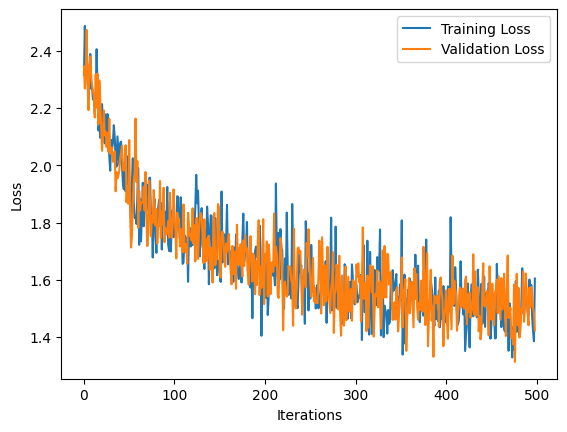

Test Accuracy: 52.64%


In [59]:
model = Model1()

train(model, batch_size=32, num_iters=5000, show_graph=False, lr=0.0005, num_checkpoints=500,
      data=geo_data, labels=geo_labels, validation_data=valid_geo_data, validation_labels=valid_geo_labels)
get_accuracy(model, valid_geo_data, valid_geo_labels)
torch.save(model, './models/model1.pt')

100%|██████████| 5000/5000 [04:47<00:00, 17.42it/s]


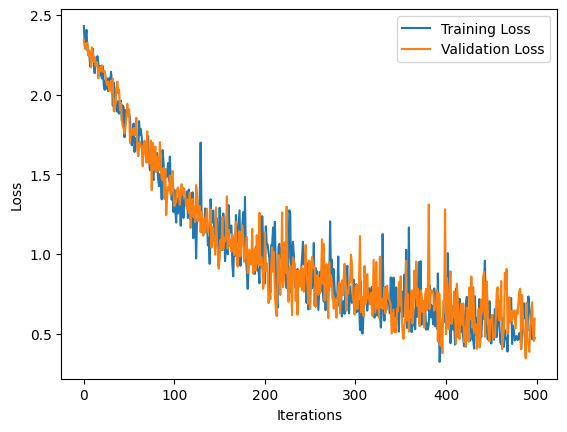

Test Accuracy: 82.42%


In [60]:
model2 = Model2()

train(model2, batch_size=32, num_iters=5000, show_graph=False, lr=0.0005, num_checkpoints=500,
      data=geo_data, labels=geo_labels, validation_data=valid_geo_data, validation_labels=valid_geo_labels,)
get_accuracy(model2, valid_geo_data, valid_geo_labels)

torch.save(model2, "./models/linear_lstm.pt")

In [ ]:
geo_data_unsqueezed, geo_labels_unsqeezed = data_generation.get_data_unsqueezed('./generated/geo_data.pickle', './generated/geo_labels.pickle')
valid_geo_data_unsqueezed, valid_geo_labels_unsqueezed = data_generation.get_data_unsqueezed('./generated/geo_validation_data.pickle', './generated/geo_validation_labels.pickle')

100%|██████████| 5000/5000 [05:57<00:00, 13.97it/s]


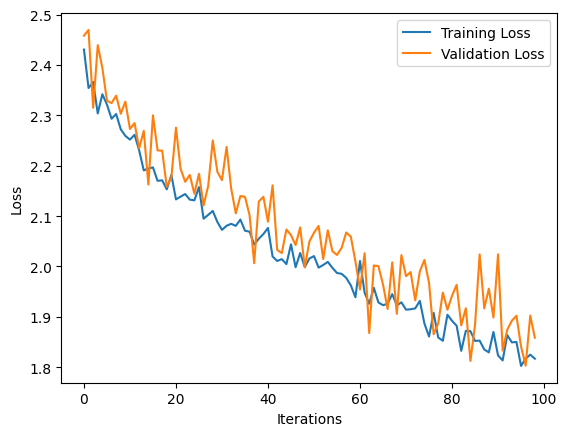

Test Accuracy: 46.38%


In [64]:
model3 = Model3()
train(model3, batch_size=10, num_iters=5000, num_checkpoints=100, lr=0.0001,
      data=geo_data_unsqueezed, labels=geo_labels_unsqeezed, validation_data=valid_geo_data_unsqueezed, validation_labels=valid_geo_labels_unsqueezed)
get_accuracy(model3, valid_geo_data_unsqueezed, valid_geo_labels_unsqueezed)
torch.save(model3, './models/model3.pt')

100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


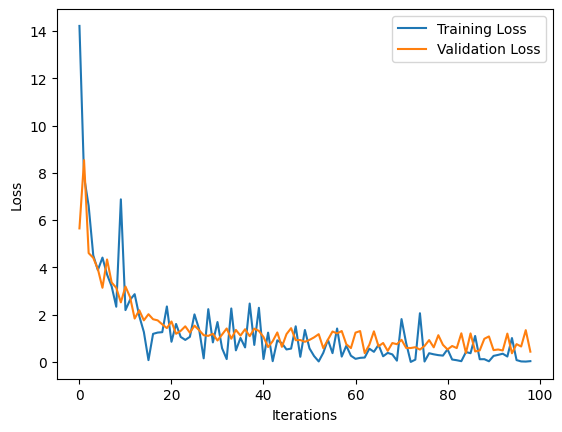

Test Accuracy: 81.42%


In [65]:
model4 = Model4()
train(model4, batch_size=32, num_iters=100, num_checkpoints=100, lr=0.0001, 
      data=geo_data_unsqueezed, labels=geo_labels_unsqeezed, validation_data=valid_geo_data_unsqueezed, validation_labels=valid_geo_labels_unsqueezed)
get_accuracy(model4, valid_geo_data_unsqueezed, valid_geo_labels_unsqueezed)
torch.save(model4.state_dict(), './models/model4.pt')

# Inny zbiór danych

Teraz zobaczmy jak te modele radzą sobie na innym zbiorze danych:

W drugim teście mamy:

$t_c$ - $20$ (stała)

$n$ - Uni(5, 10)

$p = 0.3$ 

Te dane są o wiele bardziej zaszumione (30% pikseli to szum!). Ponad to czas trwania każdej z cyfr wynosi zawsze $20$ (np. jeśli przez 20 ostatnich klatek odczytywano jedną cyfrę, to można się spodziewać, że w następnej klatce nastąpi zmiana)

Przy tak mocnym zaszumieniu oraz stałym $t_c$ spodziewam się, że modele rekurencyjne będą mieć przewagę nad klasycznymi.

In [74]:
def no_img_func2():
    return np.random.randint(5, 10+1)

def len_func2():
    return 20

noise_prob2 = 0.3

In [76]:
data_generation.gen_and_export_data(3000,
                                    noise_prob=noise_prob,
                                    no_imgs_func=no_img_func2,
                                    img_len_func=len_func2,
                                    data_path='./generated/uni_data.pickle',
                                    labels_path='./generated/uni_labels.pickle',)


data_generation.gen_and_export_data(500,
                                    noise_prob=noise_prob,
                                    no_imgs_func=no_img_func2,
                                    img_len_func=len_func2,
                                    data_path='./generated/valid_uni_data.pickle',
                                    labels_path='./generated/valid_uni_labels.pickle',)


Processing:   0%|          | 0/3000 [00:00<?, ?iteration/s]

Processing: 100%|██████████| 3000/3000 [09:27<00:00,  5.29iteration/s]


saved 3000 videos to ./generated/uni_data.pickle and ./generated/uni_labels.pickle
Size of data file: 334 MB
Size of labels file: 0 MB


Processing: 100%|██████████| 500/500 [01:34<00:00,  5.30iteration/s]


saved 500 videos to ./generated/valid_uni_data.pickle and ./generated/valid_uni_labels.pickle
Size of data file: 55 MB
Size of labels file: 0 MB


In [7]:
uni_data, uni_labels = data_generation.get_data_squeezed('./generated/uni_data.pickle', './generated/uni_labels.pickle')
valid_uni_data, valid_uni_labels = data_generation.get_data_squeezed('./generated/valid_uni_data.pickle', './generated/valid_uni_labels.pickle')

In [8]:
uni_data_unsqueezed, uni_labels_unsqueezed = data_generation.get_data_unsqueezed('./generated/uni_data.pickle', './generated/uni_labels.pickle')
valid_uni_data_unsqueezed, valid_uni_labels_unsqueezed = data_generation.get_data_unsqueezed('./generated/valid_uni_data.pickle', './generated/valid_uni_labels.pickle')

100%|██████████| 5000/5000 [05:18<00:00, 15.69it/s]


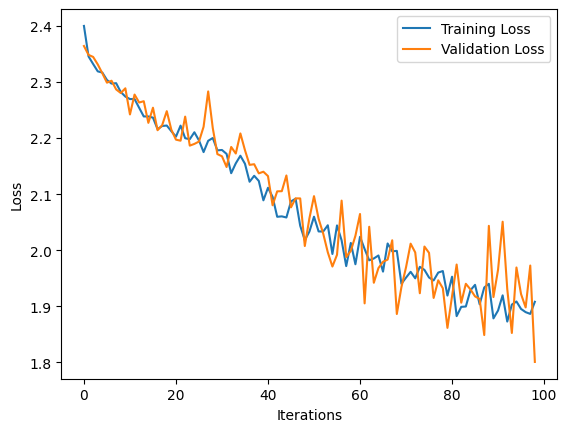

Test Accuracy: 43.27%


In [80]:
model1b = Model1()
train(model1b, batch_size=32, num_iters=5000, num_checkpoints=100, lr=0.0001,
      data=uni_data, labels=uni_labels, validation_data=valid_uni_data, validation_labels=valid_uni_labels)

get_accuracy(model1b, valid_uni_data, valid_uni_labels)
torch.save(model1b, './models/model1b.pt')

`Model1` prawdopodobnie ma jeszcze potencjał do daleszej nauki, ale 5 min to dość sporo, więc idźmy dalej

100%|██████████| 5000/5000 [05:52<00:00, 14.19it/s]


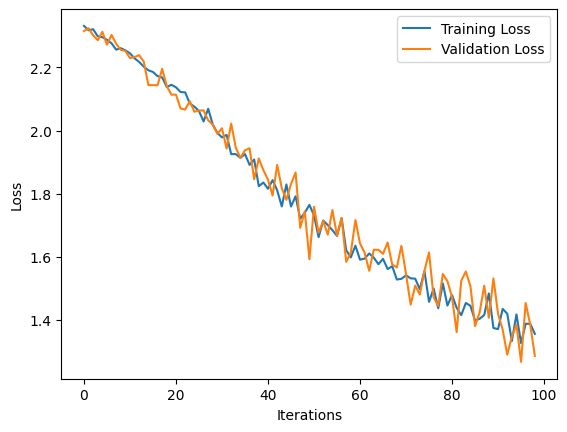

Test Accuracy: 58.56%


In [81]:
model2b = Model2()
train(model2b, batch_size=32, num_iters=5000, num_checkpoints=100, lr=0.0001,
      data=uni_data, labels=uni_labels, validation_data=valid_uni_data, validation_labels=valid_uni_labels)

get_accuracy(model2b, valid_uni_data, valid_uni_labels)
torch.save(model2b, './models/model2b.pt')

`Model2` radzi sobie lepiej - choć wciąż uczy się dość wolno

100%|██████████| 5000/5000 [23:30<00:00,  3.54it/s]


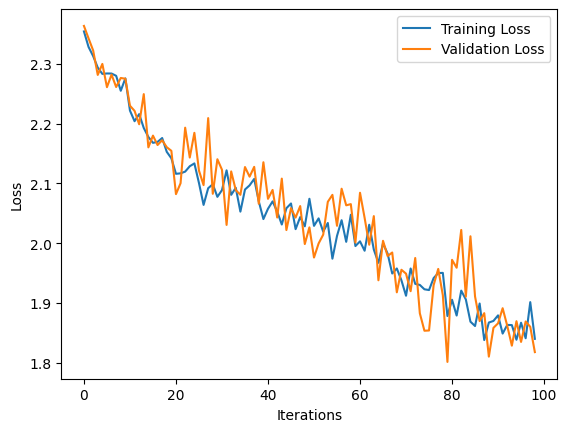

Test Accuracy: 42.33%


In [82]:
model3b = Model3()
train(model3b, batch_size=32, num_iters=5000, num_checkpoints=100, lr=0.0001,
      data=uni_data_unsqueezed, labels=uni_labels_unsqueezed, validation_data=valid_uni_data_unsqueezed, validation_labels=valid_uni_labels_unsqueezed)

get_accuracy(model3b, valid_uni_data_unsqueezed, valid_uni_labels_unsqueezed)
torch.save(model3b, './models/model3b.pt')

`Model3` również na tym zbiorze danych wypadł bardzo słabo - 23 minuty uczenia i tylko 42% poprawności

100%|██████████| 500/500 [10:51<00:00,  1.30s/it]


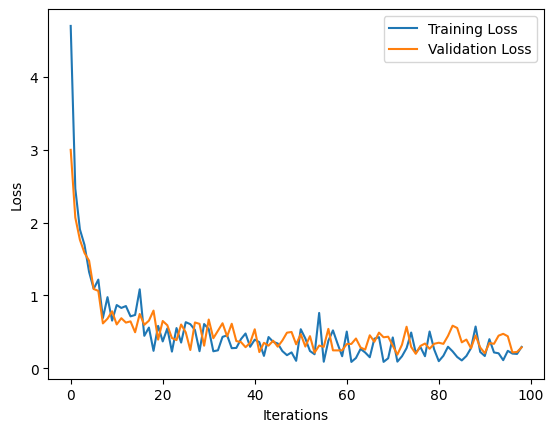

Test Accuracy: 91.33%


In [84]:
model4b = Model4()
train(model4b, batch_size=32, num_iters=500, num_checkpoints=100, lr=0.0001,
      data=uni_data_unsqueezed, labels=uni_labels_unsqueezed, validation_data=valid_uni_data_unsqueezed, validation_labels=valid_uni_labels_unsqueezed)

get_accuracy(model4b, valid_uni_data_unsqueezed, valid_uni_labels_unsqueezed)
torch.save(model4b, './models/model4b.pt')

`Model4` wypadł zdecydowanie najlepiej - 11 minut uczenia i 91% dokładności - choć uczenie możnaby przerwać po mniej niż połowie tego czasu osiągając podobny efekt. 

In [ ]:
import os
torch.save(model2, "./models/linear_lstm.pt")
size = os.path.getsize("./models/linear_lstm.pt")/1024
print(f"linear lstm: {size} KB")

size = os.path.getsize("./models/simple_lstm.pt")/1024
print(f"simple lstm: {size} KB")

100%|██████████| 10000/10000 [11:37<00:00, 14.33it/s]


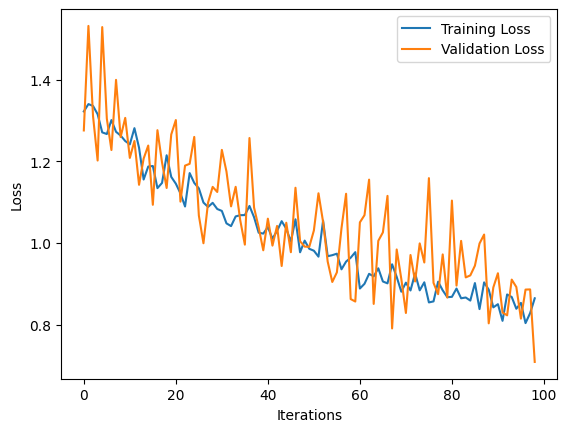

Test Accuracy: 70.34%


In [85]:
model2c = Model2()
train(model2b, batch_size=32, num_iters=10000, num_checkpoints=100, lr=0.0001,
      data=uni_data, labels=uni_labels, validation_data=valid_uni_data, validation_labels=valid_uni_labels)

get_accuracy(model2b, valid_uni_data, valid_uni_labels)
torch.save(model2b, './models/model2b.pt')

`Model2` - jeszcze jedna sesja uczenia - tym razem na 10k batchy - osiągnął 70%, przy czym funkcja straty zdaje się nie wypłaszczać, więc jest nadzieja na lepszy wynik

# Wnioski

`Model3` pokazał, że z jakiegoś powodu obecne ustawienie nie radzi sobie dobrze z konwolucją przed LSTM
`Model4` pokazał, że klasyczna sieć dobrze sobie radzi z danymi

Spróbujmy rozszerzyć `Model2` - zrobić coś pomiędzy modelem 2 i 4:

In [10]:
class Model5(nn.Module):
    def init_hidden(self):
        self.hidden = torch.zeros(1, self.hidden_size)
        self.context = torch.zeros(1, self.hidden_size)
    
    def __init__(self, hidden_size=20, layers=[10, 10]):
        super(Model5, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.lstm = nn.LSTM(28*28, hidden_size)
        self.linears = nn.ModuleList()
        self.linears.append(nn.Linear(hidden_size, layers[0]))
        for i in range(len(layers)-1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
            self.linears[i].requires_grad = True
        
        self.init_hidden()
        
    def forward(self, x):
        out, (self.res_hidden, self.res_context) = self.lstm(x, (self.hidden, self.context))

        for linear in self.linears:
            out = linear(out)
            out = nn.ReLU()(out)
        return out, (self.res_hidden, self.res_context)
    
    

print(f"Model 5 has {get_param_num(Model5(20, [20, 20, 10]))} parameters")

Model 5 has 65530 parameters


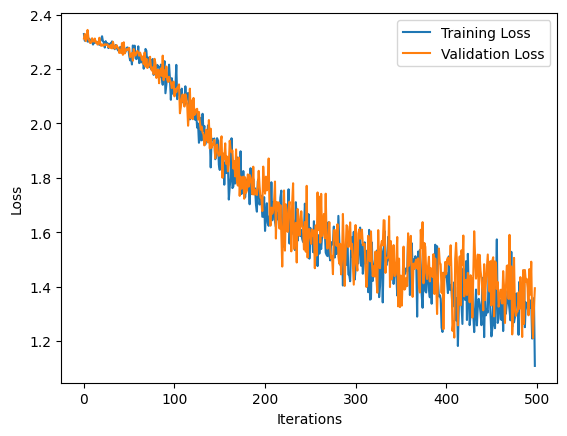

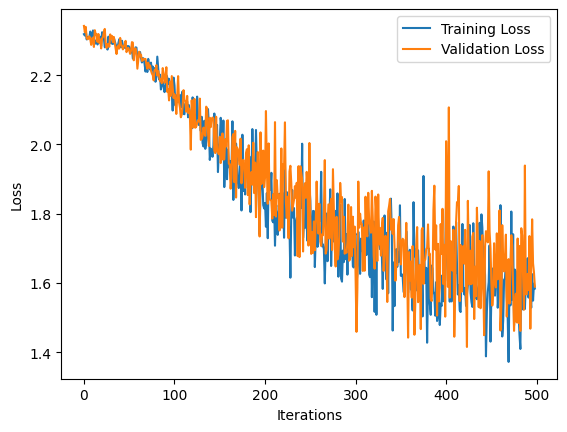

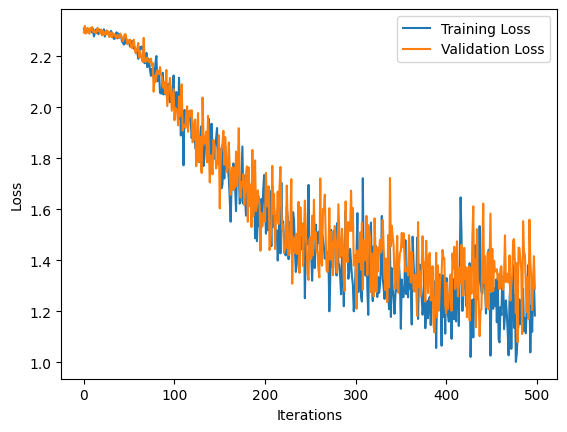

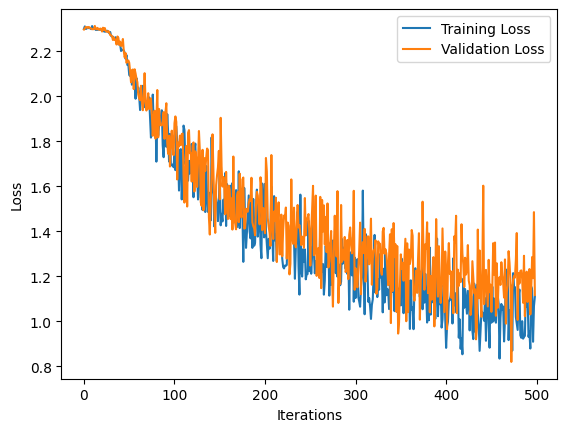

Test Accuracy: 56.89%
Test Accuracy: 61.99%
Test Accuracy: 51.53%
Test Accuracy: 44.74%
{Model5(
  (lstm): LSTM(784, 20)
  (linears): ModuleList(
    (0-1): 2 x Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
): 56.888590604026845, Model5(
  (lstm): LSTM(784, 30)
  (linears): ModuleList(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
): 61.986577181208055, Model5(
  (lstm): LSTM(784, 10)
  (linears): ModuleList(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
): 51.526174496644295, Model5(
  (lstm): LSTM(784, 16)
  (linears): ModuleList(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1-2): 2 x Linear(in_features=10, out_features=10, b

In [12]:
import threading

model5d = Model5(20, [20, 20, 10])
model5e = Model5(30, [30, 20, 20, 10])
model5f = Model5(10, [50, 10])
model5g = Model5(16, [10, 10, 10])

models = [model5d, model5e, model5f, model5g]

def train_model(model):
    train(model, batch_size=64, num_iters=7000, num_checkpoints=500, lr=0.00005,
          data=uni_data, labels=uni_labels, validation_data=valid_uni_data, validation_labels=valid_uni_labels, show_progrss_bar=False)

threads = []
for model in models:
    thread = threading.Thread(target=train_model, args=(model,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

acc = {}

for model in models:
    acc[model] = get_accuracy(model, valid_uni_data, valid_uni_labels)
    
print(acc)
    

LSTM nie jest dobrym rozwiązaniem tego problemu - lub nie umiem go dobrze nauczyć.

Do poprawy: 
    lepsze (równoległe) przetwarzanie batchy. Nie udało mi się tego wykonać za pomocą istniejącej architektury w torch'u, bo dane mają różny rozmiar i torch ma z tym problemy.

Możliwe dalsze kroki:
    Sprawdzić jak wyszkolone modele radzą sobie z innymi danymi (inne rozkłady czasu trwania pojedyńczej cyfry, inny poziom zaszumienia)